# Homographies

In this notebook, we will explore the estimation and use of homographies

In [1]:
%pylab 
#import matplotlib.pyplot as plt, import numpy as np

%matplotlib inline 
#display matplotlib figures as inline text

#import utilities
from PIL import Image #reading and writing images
from skimage.transform import warp #warping images

#function to read in image and convert it to float
def imread(imgfile):
    img = Image.open(imgfile).convert('RGB')
    img = np.array(img)
    return img.astype(float)/255.



Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## The image and the correspondences

We will first load up our image. We will use a perspective view of a chessboard as our input image. On the chessboard, we will assume a world coordinate system with the origin on one corner of the chessboard and X and Y axes along the two edges of the chessboard. We will assume units so that each square on the chessboard is 10 units x 10 units.

We will use 4 points to estimate the homography between the chessboard and the image.

Let's visualize the image and the input correspondences.

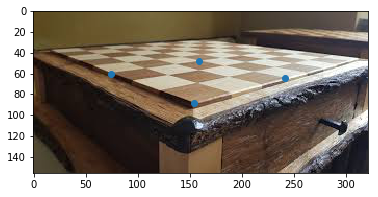

In [2]:
img = imread('chessboard.jpeg')
image_coords = np.array([[154, 88], [74, 60], [159, 48], [242,64]])
world_coords = np.array([[0,0], [0,30], [30,30], [30,0]])
plt.figure(); plt.imshow(img); plt.scatter(image_coords[:,0], image_coords[:,1])

## Estimating the homography

Let's estimate the homography now.
For this, we want to set up a system of linear equations based on the correspondences.
Let us see how we can do that.
We have:
$$\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \equiv \begin{bmatrix} H_{11} & H_{12} & H_{13} \\ H_{21} & H_{22} & H_{23} \\ H_{31} & H_{32} & H_{33} \end{bmatrix} \begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}$$
$$\Rightarrow \begin{bmatrix} \lambda x \\ \lambda y \\ \lambda  \end{bmatrix} = \begin{bmatrix} H_{11} & H_{12} & H_{13} \\ H_{21} & H_{22} & H_{23} \\ H_{31} & H_{32} & H_{33} \end{bmatrix} \begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}$$
for some $\lambda$.

Substituting the last equation into the first two, we get the following two equations for each correspondence.
$$ H_{11}X + H_{12} Y + H_{13} - H_{31} Xx - H_{32} Yx - H_{33} = 0 $$
$$ H_{21}X + H_{22} Y + H_{23} - H_{31} Xy - H_{32} Yy - H_{33} = 0 $$

This in turn can be written as a matrix vector equation:
$$\begin{bmatrix} X & Y & 1 & 0 & 0 & 0 & -Xx & -Yx & -1 \\ 0 & 0 & 0 & X & Y & 1 & -Xy & -Yy & -1 \end{bmatrix} \begin{bmatrix} H_{11} \\ H_{12} \\ \vdots \\ H_{33} \end{bmatrix} = \mathbf{0}$$
Let us set these equations up first.


In [3]:
def get_coeffs_from_single_correspondence(x,y, X, Y):
    A = np.zeros((2,9)) # 2 equations, 9 variables
    
    #eqn 1 corresponding to x coordinate
    A[0,0] = X
    A[0,1] = Y
    A[0,2] = 1
    A[0,6] = -x*X
    A[0,7] = -x*Y
    A[0,8] = -x
    
    #eqn 2 corresponding to y coordinate
    A[1,3] = X
    A[1,4] = Y
    A[1,5] = 1
    A[1,6] = -y*X
    A[1,7] = -y*Y
    A[1,8] = -y
    
    return A
    
all_coeffs = [get_coeffs_from_single_correspondence(image_coords[i,0],\
                        image_coords[i,1], world_coords[i,0], world_coords[i,1])\
             for i in range(image_coords.shape[0])]
A = np.concatenate(all_coeffs, axis=0)
print(A.shape)
    
    
    

(8, 9)


Now let us solve this system of equations. As discussed in the lecture, we will add the constraint that $\|H\|_F = 1$, which in terms of the vector of variables $\mathbf{h} = \begin{bmatrix} H_{11} \\ H_{12} \\ \vdots \\ H_{33}\end{bmatrix}$ amounts to the constraint that $\|\mathbf{h}\| = 1$.

We will optimize for the following objective as discussed:
$$\min_{\mathbf{h}} \|A\mathbf{h}\|^2$$
s.t
$$\|\mathbf{h}\| = 1$$.

In the lecture on camera calibration, we discussed how this can be done using an SVD. We will do that below.

In [5]:
def solve_for_h(A):
    
    U, s, VT = np.linalg.svd(A)
    #singular values are sorted in decreasing order
    y = np.zeros(9)
    y[-1] = 1
    h = np.dot(VT.T,y)
    return h.reshape((3,3))

H = solve_for_h(A)

## Warping the image using the homography
Once we have the homography we can figure out how the plane in question actually looks like without the perspective projection. All we need to do is to use the inverse of the homography to map the image coordinates back to the plane coordinates.

Fortunately, skimage's warp function does exactly this.

Let us see what the original plane looks like!

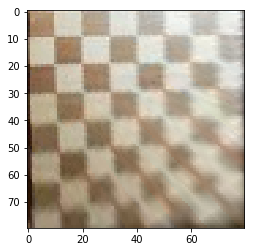

In [6]:
orig_plane = warp(img, H, output_shape=(80,80))
plt.figure(); plt.imshow(orig_plane)